In [1]:
import imageio
import numpy as np
from pathlib import Path
from omegaconf import OmegaConf
import os
from IPython.display import display, Image
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn import linear_model
import torch.nn.functional as F
import torch
import yaml
import lpips
import collections
import scipy.signal

def disp_im(im):
    plt.close()
    plt.cla()
    fig = plt.imshow(im.copy())
    plt.close()
    display(fig.figure)

def merge_dicts(*dicts):
    res = dict()
    for d in dicts:
        for k, v in d.items():
            res[k] = v
    return res

In [2]:
def rgb_ssim(img0, img1, max_val,
             filter_size=11,
             filter_sigma=1.5,
             k1=0.01,
             k2=0.03,
             return_map=False):
    # Modified from https://github.com/google/mipnerf/blob/16e73dfdb52044dcceb47cda5243a686391a6e0f/internal/math.py#L58
    assert len(img0.shape) == 3
    assert img0.shape[-1] == 3
    assert img0.shape == img1.shape

    # Construct a 1D Gaussian blur filter.
    hw = filter_size // 2
    shift = (2 * hw - filter_size + 1) / 2
    f_i = ((np.arange(filter_size) - hw + shift) / filter_sigma)**2
    filt = np.exp(-0.5 * f_i)
    filt /= np.sum(filt)

    # Blur in x and y (faster than the 2D convolution).
    def convolve2d(z, f):
        return scipy.signal.convolve2d(z, f, mode='valid')

    filt_fn = lambda z: np.stack([
        convolve2d(convolve2d(z[...,i], filt[:, None]), filt[None, :])
        for i in range(z.shape[-1])], -1)
    mu0 = filt_fn(img0)
    mu1 = filt_fn(img1)
    mu00 = mu0 * mu0
    mu11 = mu1 * mu1
    mu01 = mu0 * mu1
    sigma00 = filt_fn(img0**2) - mu00
    sigma11 = filt_fn(img1**2) - mu11
    sigma01 = filt_fn(img0 * img1) - mu01

    # Clip the variances and covariances to valid values.
    # Variance must be non-negative:
    sigma00 = np.maximum(0., sigma00)
    sigma11 = np.maximum(0., sigma11)
    sigma01 = np.sign(sigma01) * np.minimum(
        np.sqrt(sigma00 * sigma11), np.abs(sigma01))
    c1 = (k1 * max_val)**2
    c2 = (k2 * max_val)**2
    numer = (2 * mu01 + c1) * (2 * sigma01 + c2)
    denom = (mu00 + mu11 + c1) * (sigma00 + sigma11 + c2)
    ssim_map = numer / denom
    ssim = np.mean(ssim_map)
    return ssim_map if return_map else ssim

device = torch.device('cuda')
loss_fn_alex = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/dronelab/miniconda3/envs/31/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dronelab/miniconda3/envs/31/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/dronelab/miniconda3/envs/31/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [25]:
def fit_bg_color(pred_bg, gt_bg, f, f_inv, reject_outliers=True):
    fH = pred_bg.shape[0]
    sin_vals = np.sin(np.arange(fH) / fH * np.pi).reshape(-1, 1, 1)
    X = f((pred_bg)[:fH//2].reshape(-1, 3))
    Y = f((gt_bg)[:fH//2].reshape(-1, 3))
    # X = f((pred_bg).reshape(-1, 3))
    # Y = f((gt_bg).reshape(-1, 3))

    if reject_outliers:
        bY = np.mean(Y, axis=1)
        S = np.std(bY)*3
        outlier = (bY < np.mean(bY) - S) | (bY > np.mean(bY) + S)
        X = X[~outlier].clip(0, 1e9)
        Y = Y[~outlier]
    fullX = f((pred_bg).reshape(-1, 3))
    fullX = fullX.clip(0, 1e9)
    

    B = np.mean(Y - X, axis=0, keepdims=True)

    M = (np.mean((X) * Y, axis=0) / np.mean((X)**2, axis=0)).reshape(1, 3)

    fit_bg = np.zeros_like(fullX)
    for ci in range(3):
        model = linear_model.LinearRegression()
        model.fit(X[:, ci:ci+1], Y[:, ci:ci+1])
        fit_bg[:, ci:ci+1] = model.predict(fullX[:, ci:ci+1])
        # model = linear_model.HuberRegressor()
        # model.fit(X[:, ci:ci+1], Y[:, ci])
        # fit_bg[:, ci] = model.predict(fullX[:, ci:ci+1])
        
    # print('post_reg', fit_bg.mean(axis=0), Y.mean(axis=0))
    if reject_outliers:
        fit_bg = (M*fullX).reshape(pred_bg.shape)
    else:
        fit_bg = (fullX+B).reshape(pred_bg.shape)
    # return fullX.reshape(pred_bg.shape)
    return f_inv(fit_bg.reshape(pred_bg.shape)), M


../log/noprednorms_nl0_conserve_pb0/mic_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_norussian_noprednorms_nl0


/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))
/tmp/ipykernel_219405/48830211.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.04131410514455428, 'envmap_ssim_top': 0.052345218673533006, 'envmap_lpips_top': 1.053192138671875, 'envmap_psnr': 11.716435536520468, 'envmap_psnr_top': 12.73199591659705, 'envmap_smape': 84.09322044371739, 'envmap_smape_top': 134.46243526632543}


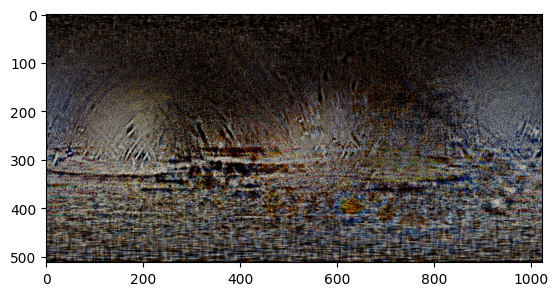

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


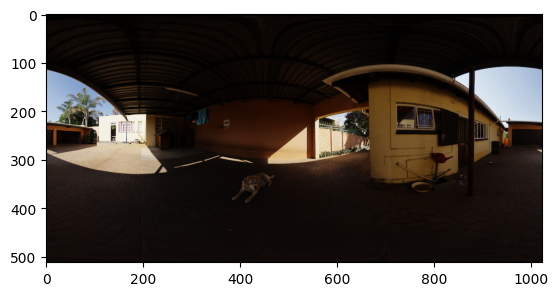

/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/noprednorms_nl0_conserve_pb0/helmet_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_noprednorms_nl0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.3919632366913835, 'envmap_ssim_top': 0.5730561110077185, 'envmap_lpips_top': 0.5874636769294739, 'envmap_psnr': 12.427556220358547, 'envmap_psnr_top': 22.85039329737465, 'envmap_smape': 41.680049690235535, 'envmap_smape_top': 30.29403157285195}


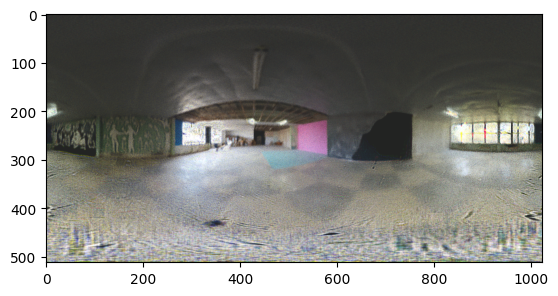

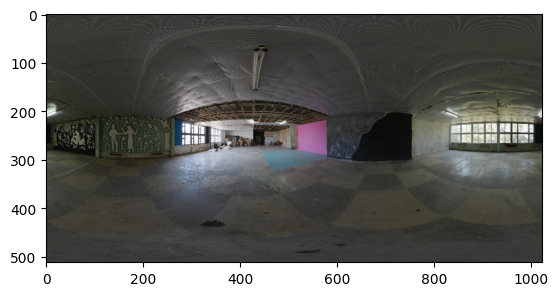

../log/noprednorms_nl0_conserve_pb0/toaster_v38


/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))
/tmp/ipykernel_219405/48830211.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.2382018298906416, 'envmap_ssim_top': 0.3554896276424996, 'envmap_lpips_top': 0.925021231174469, 'envmap_psnr': 9.574861420415836, 'envmap_psnr_top': 18.32430421702698, 'envmap_smape': 64.2629148552603, 'envmap_smape_top': 54.09192696009358}


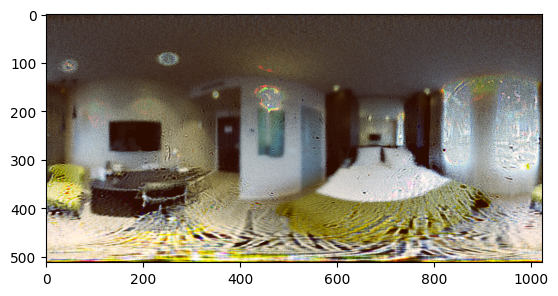

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


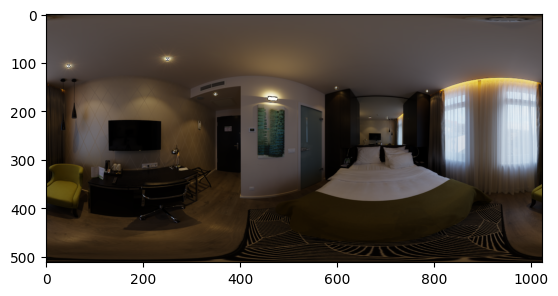

/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/noprednorms_nl0_conserve_pb0/teapot_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_norussian_noprednorms_nl0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.2918667754181608, 'envmap_ssim_top': 0.5290126072559455, 'envmap_lpips_top': 0.7018845081329346, 'envmap_psnr': 8.050117313098557, 'envmap_psnr_top': 17.229117562953945, 'envmap_smape': 66.53386286198436, 'envmap_smape_top': 46.840497867289194}


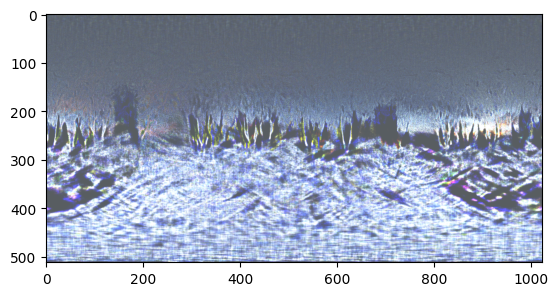

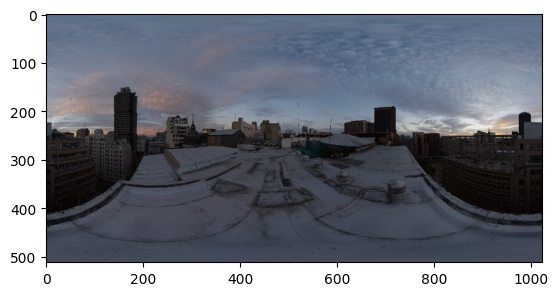

../log/noprednorms_nl0_conserve_pb0/ficus_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_norussian_noprednorms_nl0


/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))
/tmp/ipykernel_219405/48830211.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.05532936450620725, 'envmap_ssim_top': 0.06026744167741164, 'envmap_lpips_top': 1.23533296585083, 'envmap_psnr': 13.30192624569841, 'envmap_psnr_top': 13.984022546415405, 'envmap_smape': 58.82027385200627, 'envmap_smape_top': 80.6741262992151}


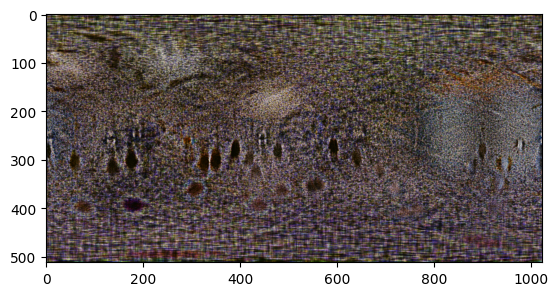

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


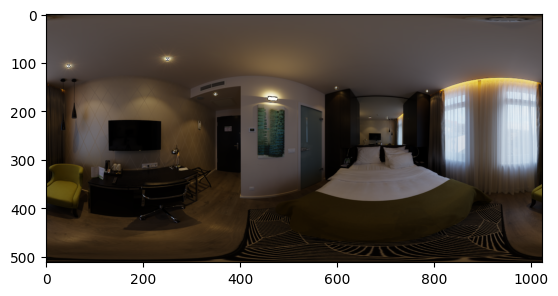

/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/noprednorms_nl0_conserve_pb0/materials_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_norussian_noprednorms_nl0


/tmp/ipykernel_219405/48830211.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.24830046104214165, 'envmap_ssim_top': 0.12110656514542383, 'envmap_lpips_top': 0.5740629434585571, 'envmap_psnr': 17.324969161894476, 'envmap_psnr_top': 14.763946063175245, 'envmap_smape': 50.63241374936149, 'envmap_smape_top': 85.77988833656241}


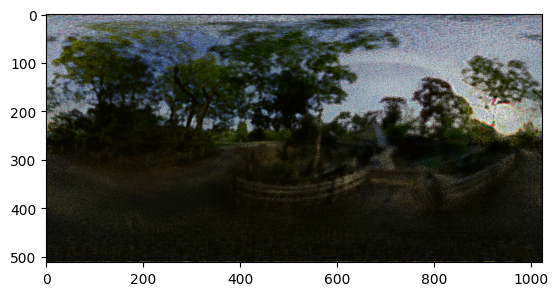

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


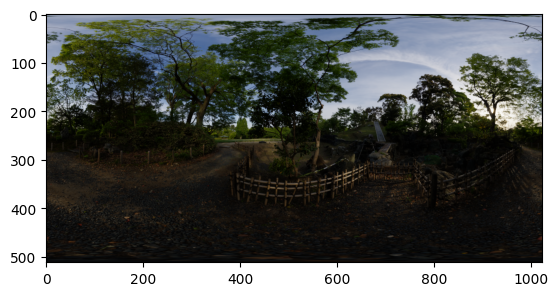

/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/noprednorms_nl0_conserve_pb0/chair_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_norussian_noprednorms_nl0


/tmp/ipykernel_219405/48830211.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.08716488224652555, 'envmap_ssim_top': 0.1401385271413948, 'envmap_lpips_top': 1.17225980758667, 'envmap_psnr': 10.671540141702938, 'envmap_psnr_top': 13.91130368420593, 'envmap_smape': 64.58806468794319, 'envmap_smape_top': 77.87911657085836}


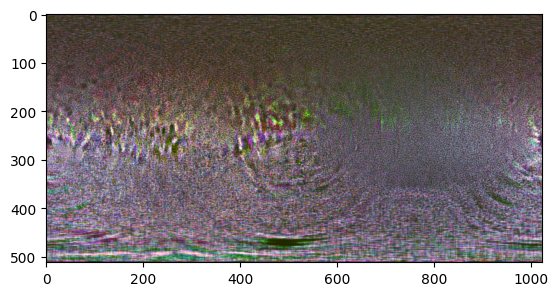

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


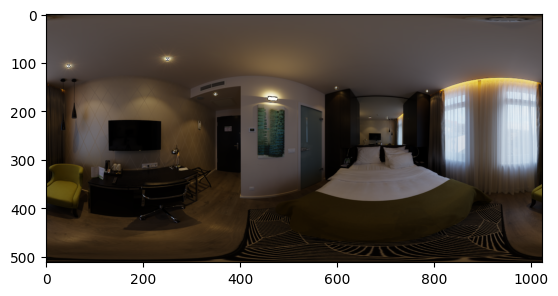

/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/noprednorms_nl0_conserve_pb0/coffee_v38


/tmp/ipykernel_219405/48830211.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gt_bg = cv.cvtColor(gt_bg, cv.COLOR_BGR2RGB).astype(np.float)/255


{'envmap_ssim': 0.28498645081234425, 'envmap_ssim_top': 0.2568751995103423, 'envmap_lpips_top': 0.6199910640716553, 'envmap_psnr': 14.391111396227657, 'envmap_psnr_top': 16.820877035056654, 'envmap_smape': 65.88293829048098, 'envmap_smape_top': 80.45330310273845}


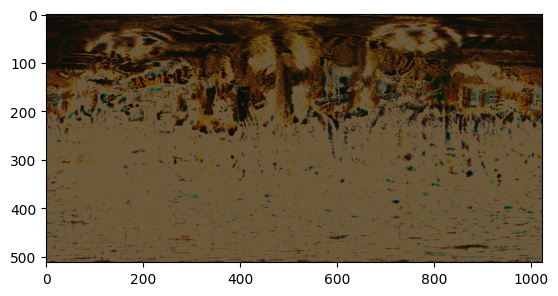

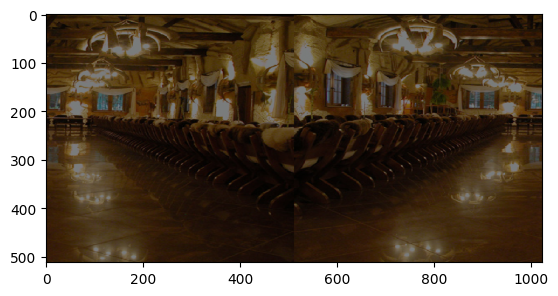

../log/noprednorms_nl0_conserve_pb0/lego_v38


/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))
/tmp/ipykernel_219405/48830211.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.06671907492150807, 'envmap_ssim_top': 0.108483945075371, 'envmap_lpips_top': 1.106816291809082, 'envmap_psnr': 9.390508802099422, 'envmap_psnr_top': 14.955509476827366, 'envmap_smape': 68.43528622115991, 'envmap_smape_top': 66.13700407341221}


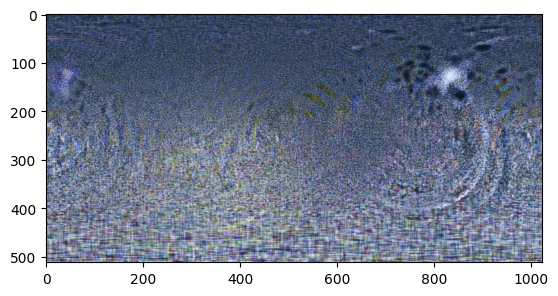

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


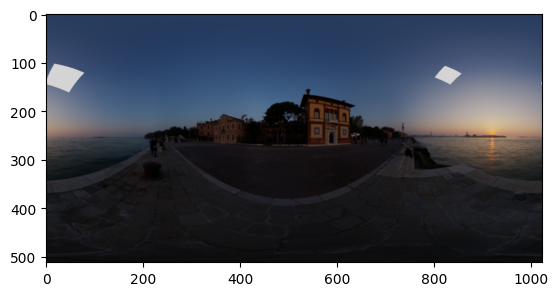

/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/noprednorms_nl0_conserve_pb0/hotdog_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_norussian_noprednorms_nl0


/tmp/ipykernel_219405/48830211.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.09886658143512529, 'envmap_ssim_top': 0.18533606519401663, 'envmap_lpips_top': 1.0116554498672485, 'envmap_psnr': 9.450997061996235, 'envmap_psnr_top': 17.98915547884901, 'envmap_smape': 73.39811331010755, 'envmap_smape_top': 61.51886995724144}


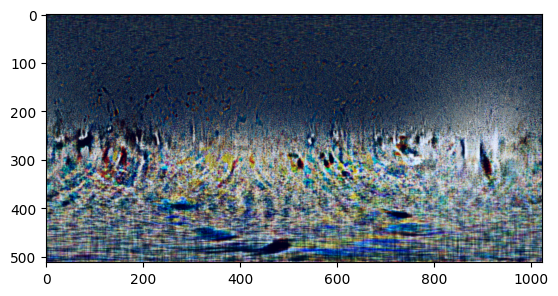

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


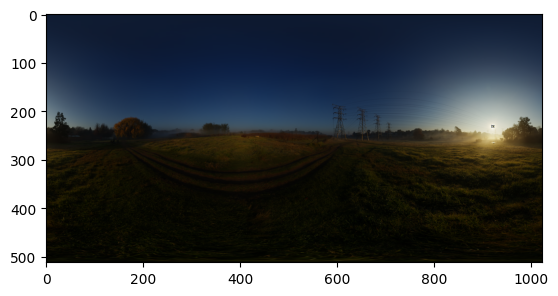

/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/noprednorms_nl0_conserve_pb0/ship_v38


/tmp/ipykernel_219405/48830211.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.17539693751107818, 'envmap_ssim_top': 0.3420026422708915, 'envmap_lpips_top': 0.8377759456634521, 'envmap_psnr': 8.536476346631229, 'envmap_psnr_top': 16.662308046193456, 'envmap_smape': 72.65023102298773, 'envmap_smape_top': 60.233540391508164}


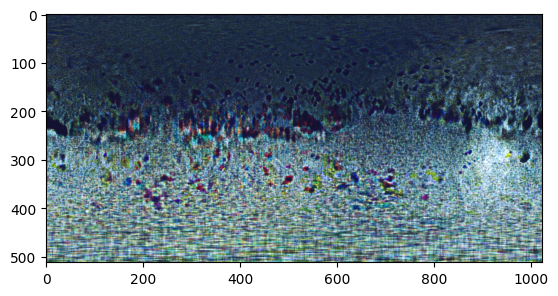

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


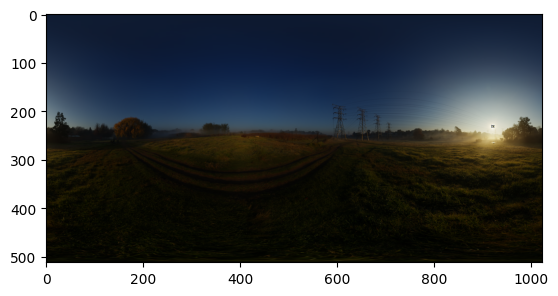

/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/noprednorms_nl0_conserve_pb0/drums_v38


/tmp/ipykernel_219405/48830211.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.06037656310461741, 'envmap_ssim_top': 0.08647163542255784, 'envmap_lpips_top': 1.0529849529266357, 'envmap_psnr': 10.441829094254413, 'envmap_psnr_top': 14.502972014065168, 'envmap_smape': 66.2699132062671, 'envmap_smape_top': 78.77987547610026}


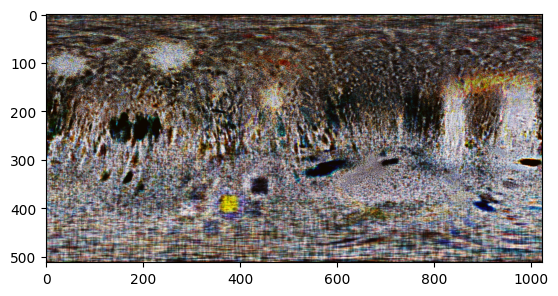

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


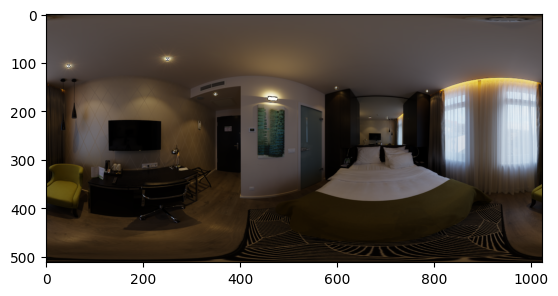

/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/noprednorms_nl0_conserve_pb0/shinyball_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_noprednorms_nl0


/tmp/ipykernel_219405/48830211.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.35458151673722094, 'envmap_ssim_top': 0.30783009779570647, 'envmap_lpips_top': 0.3724556863307953, 'envmap_psnr': 17.54382156335139, 'envmap_psnr_top': 16.320335766765872, 'envmap_smape': 59.25970521786408, 'envmap_smape_top': 83.53126281366421}


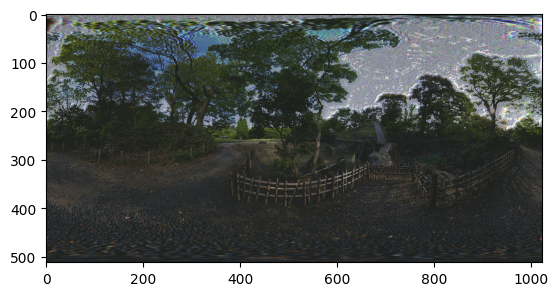

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


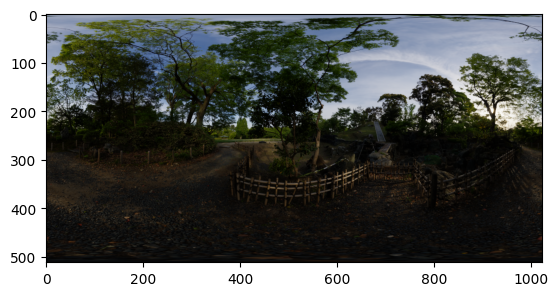

/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/noprednorms_nl0_conserve_pb0/car_v38


/tmp/ipykernel_219405/48830211.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.1879764283827794, 'envmap_ssim_top': 0.358419520925497, 'envmap_lpips_top': 0.3726620376110077, 'envmap_psnr': 8.375763312305608, 'envmap_psnr_top': 15.769843728996683, 'envmap_smape': 81.35677665394032, 'envmap_smape_top': 86.64965610555494}


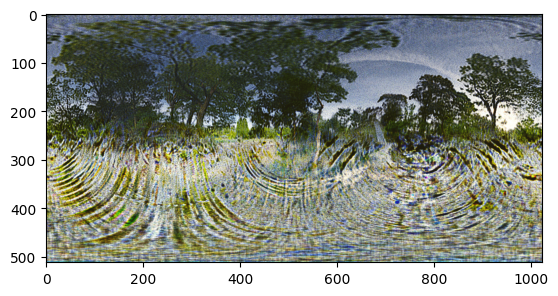

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


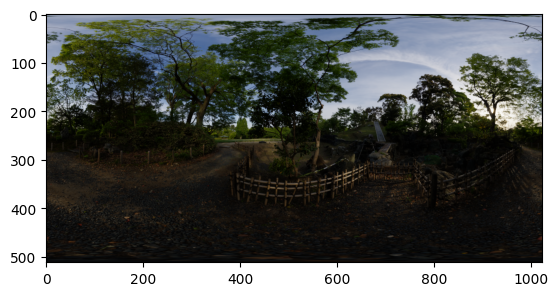

/tmp/ipykernel_219405/48830211.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_bg = imageio.imread(str(pano_path))


../log/noprednorms_nl0_conserve_pb0/ball_v37_mulLdotN_no2x_elam5e-5_max0.5rough_clip_pb0_noprednorms_nl0


/tmp/ipykernel_219405/48830211.py:65: RuntimeWarning: invalid value encountered in power
  imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'envmap_ssim': 0.18852281518782882, 'envmap_ssim_top': 0.16284648935398482, 'envmap_lpips_top': 0.9500391483306885, 'envmap_psnr': 17.81651677891756, 'envmap_psnr_top': 15.473370698368882, 'envmap_smape': 61.28756197885913, 'envmap_smape_top': 93.79369382276472}


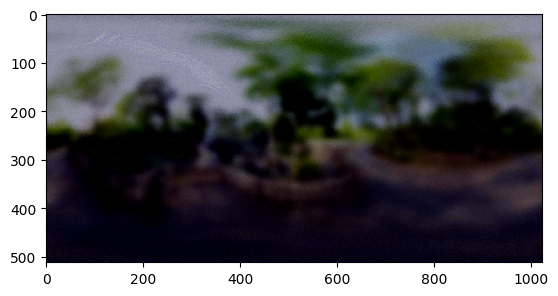

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


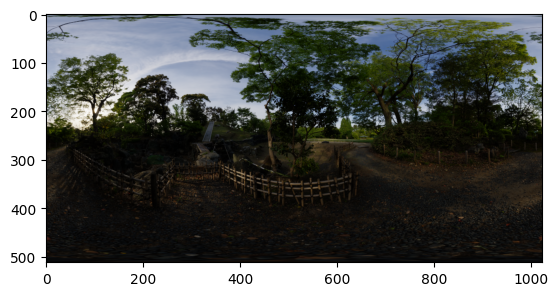

In [30]:
gt_bgs = dict(
    chair='interior.exr',
    ball='forest.exr',
    lego='lego_bg.exr',
    coffee='rj1.jpg',
)
# log_dir = Path("../log") / "fixedmip128"

# log_dir = Path("../log") / "noprednorms_nl0"
# log_dir = Path("../log") / "singlebounce_samen"
# exps = ["noprednorms_nl0_conserve_pb0", 'fixedmip128', 'tensorf', 'singlebounce_samen']
exps = ["noprednorms_nl0_conserve_pb0"]#, 'fixedmip128', 'tensorf', 'singlebounce_samen']
for exp in exps:
    log_dir = Path("../log") / exp
    for p in log_dir.glob("*"):
        print(p)
        pano_path = p / "imgs_test_all" / "envmaps" / "pano.exr"
        mapped_pano_path = p / "imgs_test_all" / "envmaps" / "mapped_pano.png"
        old_data_path = p / "imgs_test_all" / "stats_augnl.yaml"
        new_data_path = p / "imgs_test_all" / "stats_augnle.yaml"
        config = OmegaConf.load(p / 'config.yaml')

        dname = Path(config['dataset']['scenedir']).name
        # if dname != 'car' or exp != 'noprednorms_nl0_conserve_pb0':
        #     continue
        if ('gt_bg' not in config['dataset'] or config['dataset']['gt_bg'] is None) and dname not in gt_bgs.keys():
            continue
        if dname in gt_bgs.keys():
            gt_bg_path = Path("../backgrounds") / gt_bgs[dname]
        else:
            gt_bg_path = Path("../backgrounds") / config['dataset']['gt_bg']

        pred_bg = imageio.imread(str(pano_path))
        if dname == 'coffee':
            pred_bg = pred_bg.clip(min=0, max=1)
            gt_bg = cv.imread(str(gt_bg_path), -1)
            gt_bg = cv.cvtColor(gt_bg, cv.COLOR_BGR2RGB).astype(np.float)/255
        else:
            gt_bg = cv.imread(str(gt_bg_path), -1)
            gt_bg = cv.cvtColor(gt_bg, cv.COLOR_BGR2RGB)
        fH = 512
        fW = 1024
        if dname == 'ball':
            gt_bg = gt_bg[:, ::-1].copy()

            
        resize_bg = F.interpolate(torch.as_tensor(gt_bg).permute(2, 0, 1).unsqueeze(0), (fH, fW)).squeeze(0).permute(1, 2, 0).numpy()
        flip_bg = resize_bg[:, ::-1] # flip
        flip_bg = np.concatenate([flip_bg[:, fW//2:], flip_bg[:, :fW//2]], axis=1)
        pred_bg = F.interpolate(torch.as_tensor(pred_bg).permute(2, 0, 1).unsqueeze(0), (fH, fW)).squeeze(0).permute(1, 2, 0).numpy()

        # def f(x):
        #     return np.log(np.clip(x, 1e-20, 1e20))
        
        # def f_inv(x):
        #     return np.exp(np.clip(x, -20, 20))

        def f(x):
            return x
        
        def f_inv(x):
            return x
        fit_bg, M = fit_bg_color(pred_bg, flip_bg, f, f_inv)
        imageio.imsave(mapped_pano_path, (np.clip(fit_bg**(1/2.2), 0, 1)*255).astype(np.uint8))
        imageio.imsave(p / "imgs_test_all" / "envmaps" / "gt_pano.png", (np.clip(flip_bg**(1/2.2), 0, 1)*255).astype(np.uint8))

        def f(x):
            x = np.clip(x, 0, 99)
            return x / (1+x)
        
        def f_inv(x):
            return -x/(x-1)

        fit_bg, _ = fit_bg_color(fit_bg, flip_bg, f, f_inv, reject_outliers=False)
        # flip_bg = torch.as_tensor(flip_bg).mean(dim=0, keepdims=True).mean(dim=1, keepdims=True).expand(pred_bg.shape).numpy()

        B = 0
        with (p / "imgs_test_all" / "envmaps" / "coeffs.yaml").open('w') as file:
            yaml.dump(dict(M=M.tolist(), B=B), file)

        def scale_fn(x):
            return x / (1+x)

        err = (scale_fn(flip_bg) - scale_fn(fit_bg))**2# * sin_vals * np.pi/2
        # disp_im(err)
        top_psnr = -10 * np.log(np.mean(err[:fH//2])) / np.log(10.0)
        psnr = -10 * np.log(np.mean(err)) / np.log(10.0)

        def smape_fn(x, y, w):
            return (np.abs(x - y) / (np.abs(x) + np.abs(y)).clip(min=1e-8) * 2 * w).mean() * 100
        # disp_im(v.mean(dim=-1))
        sin_vals = np.sin(np.arange(fH) / fH * np.pi).reshape(-1, 1, 1)
        smape = smape_fn((flip_bg), (fit_bg), sin_vals)
        smape_top = smape_fn((flip_bg)[:fH//2], (fit_bg)[:fH//2], sin_vals[:fH//2] * np.pi/2)
        essim = rgb_ssim(scale_fn(flip_bg), scale_fn(fit_bg), 1)
        essim_top = rgb_ssim(scale_fn(flip_bg[:fH//2]), scale_fn(fit_bg[:fH//2]), 1)

        with torch.no_grad():
            gt_bg_t = torch.as_tensor(scale_fn(flip_bg)).float().permute(2, 0, 1).unsqueeze(0).to(device)
            pred_bg_t = torch.as_tensor(scale_fn(fit_bg)).float().permute(2, 0, 1).unsqueeze(0).to(device)
            lpips_top = loss_fn_alex(gt_bg_t[:, :, :fH//2], pred_bg_t[:, :, :fH//2], normalize=True).cpu()

        data = dict(
            envmap_ssim=float(essim),
            envmap_ssim_top=float(essim_top),
            envmap_lpips_top=float(lpips_top),
            envmap_psnr=float(psnr),
            envmap_psnr_top=float(top_psnr),
            envmap_smape=float(smape),
            envmap_smape_top=float(smape_top),
        )
        print(data)


        disp_im(scale_fn(fit_bg))
        disp_im(scale_fn(flip_bg))
        # disp_im((f_inv(fit_bg))**(1/2.2))
        # disp_im((flip_bg)**(1/2.2))
        with old_data_path.open('r') as f:
            old_data = yaml.safe_load(f)
        with new_data_path.open('w') as f:
            yaml.dump(dict(merge_dicts(old_data, data)), f)

In [ ]:
print(gt_bgs)

{'chair': 'interior.exr', 'ball': 'forest.exr', 'lego': 'lego_bg.exr', 'coffee': 'rj1.jpg'}
